In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import math
import matplotlib.cm as cm

# Trying to replot equations from paper

Rational design of perfluorocarbon-free oleophobic textiles ([Nature Sustainability](https://www.nature.com/articles/s41893-020-0591-9) volume 3, pages 1059–1066, **2020**).


In [ ]:
import numpy as np


def youngs_angle(surface_tension_sv, surface_tension_sl, surface_tension_lv):
    """
    In radians.
    """
    return np.arccos((surface_tension_sv - surface_tension_sl) / surface_tension_lv)


def wenzel_angle(theta_Y, curvature_r):
    return np.arccos(np.clip(curvature_r * np.cos(theta_Y), -1, 1))


def porosity_cylindrical_fibres(spacing_btw_fibres, fibre_radius):
    """
    Parameters:
    spacing_btw_fibres (float or np.array): Spacing between fibers (2D).
    fibre_radius (float or np.array): Radius of the fiber (R). Fiber diameter is 2R.
    """
    D_fibre_star = (spacing_btw_fibres / 2 + fibre_radius) / fibre_radius
    return D_fibre_star


def theta_fibre_star(theta_Y, D_fibre_star):
    """
    Parameters:
    theta_Y (float or np.array): Young's contact angle of the fiber surface chemistry in radians.
    D_fibre_star (float or np.array): Porosity parameter of the fibers, which is the ratio of the actual fiber diameter to the effective fiber diameter.

    Returns:
    float or np.array: Apparent contact angle of a liquid on a fibrous surface in the Cassie-Baxter state in radians.
    """
    cos_theta_fibre_star = -1 + (1 / D_fibre_star) * (
        np.sin(theta_Y) + (np.pi - theta_Y) * np.cos(theta_Y)
    )
    return np.arccos(cos_theta_fibre_star)


def porosity_spherical_particles(spacing_btw_particles, particle_radius):
    """
    Parameters:
    spacing_btw_particles (float or np.array): Spacing between particles (2D).
    particle_radius (float or np.array): Radius of the particle (R). Particle diameter is 2R.
    """
    D_particle_star = (1 + spacing_btw_particles / 2 / particle_radius) ** 2
    return D_particle_star


def isolate_spacing_btw_particles(D_particle_star, particle_radius):
    """
    Parameters:
    D_particle_star (float or np.array): Porosity parameter of the particles, which is the ratio of the actual particle diameter to the effective particle diameter.
    particle_radius (float or np.array): Radius of the particle (R). Particle diameter is 2R.

    Returns:
    float or np.array: Spacing between particles (2D).
    """
    spacing_btw_particles = 2 * particle_radius * (np.sqrt(D_particle_star) - 1)
    return spacing_btw_particles


def theta_particle_star(theta_Y, D_particle_star):
    """
    Parameters:
    theta_Y (float or np.array): Young's contact angle of the particle surface chemistry in radians.
    D_particle_star (float or np.array): Porosity parameter of the particles, which is the ratio of the actual particle diameter to the effective particle diameter.

    Returns:
    float or np.array: Apparent contact angle of a liquid on a smooth surface decorated with spherical particles in radians.
    """
    cos_theta_particle_star = -1 + (np.pi * (1 + np.cos(theta_Y)) ** 2) / (
        2 * np.sqrt(3) * D_particle_star
    )
    return np.arccos(cos_theta_particle_star)


def isolate_D_particle_star(theta_Y, theta_particle_star):
    """
    Parameters:
    theta_Y (float or np.array): Young's contact angle of the particle surface chemistry in radians[^1^][1].
    theta_particle_star (float or np.array): Apparent contact angle of a liquid on a smooth surface decorated with spherical particles in radians[^2^][2].

    Returns:
    float or np.array: Porosity parameter of the particles, which is the ratio of the actual particle diameter to the effective particle diameter.
    """
    D_particle_star = (np.pi * (1 + np.cos(theta_Y)) ** 2) / (
        2 * np.sqrt(3) * (1 + np.cos(theta_particle_star))
    )
    return D_particle_star


def theta_hierarchical_star(theta_particle_star, D_fibre_star):
    """
    Parameters:
    theta_particle_star (float or np.array): Apparent contact angle of a liquid on a smooth surface decorated with spherical particles in radians.
    D_fibre_star (float or np.array): Porosity parameter of the fibers, which is the ratio of the actual fiber diameter to the effective fiber diameter.

    Returns:
    float or np.array: Apparent contact angle of a liquid on a hierarchical texture where spherical particles decorate the surface of cylindrical fibers in radians.
    """
    cos_theta_hierarchical_star = -1 + (1 / D_fibre_star) * (
        np.sin(theta_particle_star)
        + (np.pi - theta_particle_star) * np.cos(theta_particle_star)
    )
    return np.arccos(cos_theta_hierarchical_star)


def isolate_theta_particle_star_from_theta_hierarchical_star(
    theta_hierarchical_star, D_fibre_star
):
    # Rearrange the equation to solve for theta_particle_star
    cos_theta_hierarchical_star = np.cos(theta_hierarchical_star)
    theta_particle_star = np.pi - np.arccos(
        (cos_theta_hierarchical_star + 1 - (1 / D_fibre_star))
        / np.cos((cos_theta_hierarchical_star + 1) / D_fibre_star)
    )
    return theta_particle_star


def A_fibre_star(theta_Y, D_fibre_star, l_cap, R_fibre):
    """
    Parameters:
    theta_Y (float or np.array): Young's contact angle of the fiber surface chemistry in radians.
    D_fibre_star (float or np.array): Porosity parameter of the fibers, which is the ratio of the actual fiber diameter to the effective fiber diameter.
    l_cap (float or np.array): Capillary length of the liquid.
    R_fibre (float or np.array): Radius of the fiber.

    Returns:
    float or np.array: Robustness parameter of a liquid on a fibrous surface in the Cassie-Baxter state.
    """
    A_fibre_star = (l_cap / (R_fibre * (D_fibre_star - 1))) * (
        (1 - np.cos(theta_Y)) / (D_fibre_star - 1 + 2 * np.sin(theta_Y))
    )
    return A_fibre_star


def A_hierarchical_star(theta_particle_star, D_fibre_star, l_cap, R_fibre):
    """
    Parameters:
    theta_particle_star (float or np.array): Apparent contact angle of a liquid on a smooth surface decorated with spherical particles in radians.
    D_fibre_star (float or np.array): Porosity parameter of the fibers, which is the ratio of the actual fiber diameter to the effective fiber diameter.
    l_cap (float or np.array): Capillary length of the liquid.
    R_fibre (float or np.array): Radius of the fiber.

    Returns:
    float or np.array: Robustness parameter of a liquid on a hierarchical texture where spherical particles decorate the surface of cylindrical fibers.
    """
    A_hierarchical_star = (l_cap / (R_fibre * (D_fibre_star - 1))) * (
        (1 - np.cos(theta_particle_star))
        / (D_fibre_star - 1 + 2 * np.sin(theta_particle_star))
    )
    return A_hierarchical_star


def capilary_length_liquid(surface_tension_lv, liquid_density, gravity=9.81):
    return np.sqrt(surface_tension_lv / (liquid_density * gravity))


def D_fibre_max_star(theta_particle_star, l_cap, A_hierarchical_star, R_fibre):
    """
    Parameters:
    theta_particle_star (float or np.array): Apparent contact angle of a liquid on a smooth surface decorated with spherical particles in radians.
    l_cap (float or np.array): Capillary length of the liquid.
    A_hierarchical_star (float or np.array): Robustness parameter of a liquid on a hierarchical texture where spherical particles decorate the surface of cylindrical fibers.
    R_fibre (float or np.array): Radius of the fiber.

    Returns:
    float or np.array: Maximum porosity of fibers for a given apparent contact angle of particles on a smooth surface.
    """
    D_fibre_max_star = (
        1
        - np.sin(theta_particle_star)
        + np.sqrt(
            np.sin(theta_particle_star) ** 2
            + (l_cap * (1 - np.cos(theta_particle_star)))
            / (A_hierarchical_star * R_fibre)
        )
    )
    return D_fibre_max_star


def theta_fabric_2d_star(theta_Y, D_fibre_star):
    """
    Parameters:
    theta_Y (float or np.array): Young's contact angle of the fiber surface chemistry in radians.
    D_fibre_star (float or np.array): Porosity parameter of the fibers, which is the ratio of the actual fiber diameter to the effective fiber diameter.

    Returns:
    float or np.array: Apparent contact angle of a liquid on a plain weave fabric in the Cassie-Baxter state in radians.
    """
    cos_theta_fabric_star = -1 + ((2 * D_fibre_star - 1) / (D_fibre_star**2)) * (
        (np.pi - theta_Y) * np.cos(theta_Y) + np.sin(theta_Y)
    )
    return np.arccos(cos_theta_fabric_star)

In [4]:
# Parameters from experiments (flat)
# Nylon 6
youngs_angle_deg = 68.3
# # PET
# youngs_angle_deg = 72.5

youngs_angle_rad = np.deg2rad(youngs_angle_deg)

Text(0, 0.5, 'Apparent angle (deg)')

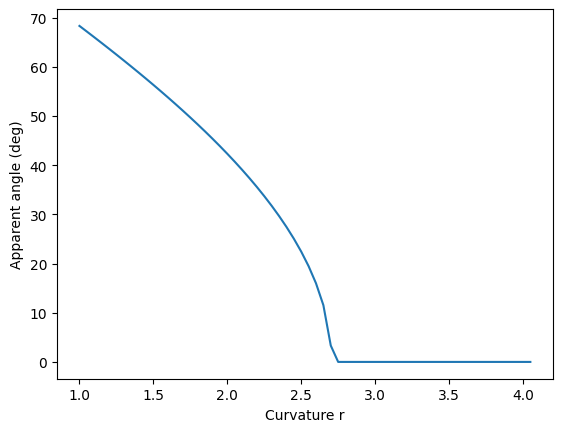

In [ ]:
curvature_r_range = np.arange(1.0, 4.1, 0.05)
wenzel_angles = wenzel_angle(youngs_angle_rad, curvature_r_range)
plt.plot(curvature_r_range, np.rad2deg(wenzel_angles))
plt.xlabel("Curvature r")
plt.ylabel("Apparent angle (deg)")

/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:31: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_fibre_star)
/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:64: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_particle_star)


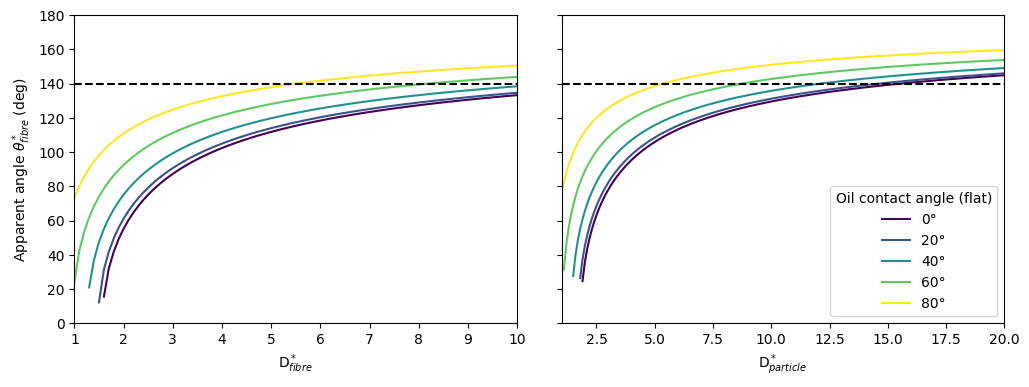

In [ ]:
# Plot the apparent angle for fibres, particles, and hierarchical
cmap = cm.viridis

D_fibre_star_range = np.arange(1.0, 11, 0.1)
D_particle_star_range = np.arange(1.0, 21, 0.1)
flat_young_contact_angle_range = np.arange(0.0, 90.0, 20)

fig, axs = plt.subplots(
    1, 2, figsize=(12, 4), sharey=True, gridspec_kw={"hspace": 0, "wspace": 0.1}
)

for i, youngs_angle_i in enumerate(flat_young_contact_angle_range):
    youngs_angle_rad_i = np.deg2rad(youngs_angle_i)
    color = cmap(
        i / (len(flat_young_contact_angle_range) - 1)
    )  # Calculate color based on the index
    thetas_fibre = theta_fibre_star(youngs_angle_rad_i, D_fibre_star_range)
    thetas_particle = theta_particle_star(youngs_angle_rad_i, D_particle_star_range)

    axs[0].plot(D_fibre_star_range, np.rad2deg(thetas_fibre), color=color)
    axs[1].plot(
        D_particle_star_range,
        np.rad2deg(thetas_particle),
        color=color,
        label=f"{youngs_angle_i:.0f}°",
    )

axs[0].hlines(
    140,
    D_fibre_star_range.min(),
    D_fibre_star_range.max(),
    linestyles="dashed",
    color="k",
)
axs[1].hlines(
    140,
    D_particle_star_range.min(),
    D_particle_star_range.max(),
    linestyles="dashed",
    color="k",
)

axs[0].set_xlabel("D$^*_{fibre}$")
axs[1].set_xlabel("D$^*_{particle}$")
axs[0].set_ylabel(r"Apparent angle $\theta^*_{fibre}$ (deg)")
axs[0].set_ylim(0, 180)
axs[0].set_xlim(1, 10)
axs[1].set_xlim(1, 20)
axs[1].legend(title="Oil contact angle (flat)")

/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:88: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_hierarchical_star)


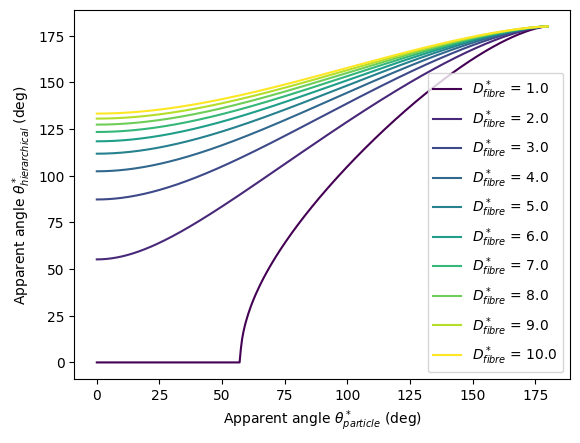

In [ ]:
theta_particle_star_range = np.arange(0.0, 180.5, 0.5)
D_fibre_star_range = np.arange(1.0, 11.0, 1)
cmap = cm.viridis  # Choose the Viridis colormap

for i, d_star in enumerate(D_fibre_star_range):
    thetas_hierarchical_star = theta_hierarchical_star(
        np.deg2rad(theta_particle_star_range), d_star
    )
    thetas_hierarchical_star = np.nan_to_num(thetas_hierarchical_star, 0)
    color = cmap(
        i / (len(D_fibre_star_range) - 1)
    )  # Calculate color based on the index
    plt.plot(
        theta_particle_star_range,
        np.rad2deg(thetas_hierarchical_star),
        color=color,
        label=f"$D_{{fibre}}^*$ = {d_star}",
    )

plt.xlabel(r"Apparent angle $\theta^*_{particle}$ (deg)")
plt.ylabel(r"Apparent angle $\theta^*_{hierarchical}$ (deg)")
plt.legend()
plt.show()

/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:150: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_fabric_star)


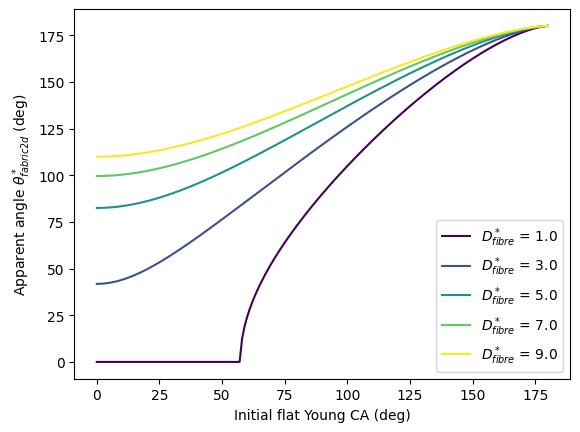

In [ ]:
# 2D model only
youngs_angle_range = np.arange(0.0, 181, 1)
D_fibre_star_range = np.arange(1.0, 11.0, 2)
cmap = cm.viridis

for i, d_fabric_star in enumerate(D_fibre_star_range):
    thetas_fabric_2d = theta_fabric_2d_star(
        np.deg2rad(youngs_angle_range), d_fabric_star
    )
    thetas_fabric_2d = np.nan_to_num(thetas_fabric_2d, 0)
    color = cmap(i / (len(D_fibre_star_range) - 1))
    plt.plot(
        youngs_angle_range,
        np.rad2deg(thetas_fabric_2d),
        color=color,
        label=f"$D_{{fibre}}^*$ = {d_fabric_star}",
    )

plt.ylabel(r"Apparent angle $\theta^*_{fabric 2d}$ (deg)")
plt.xlabel(r"Initial flat Young CA (deg)")
plt.legend()
plt.show()

/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:31: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_fibre_star)
/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:150: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta_fabric_star)


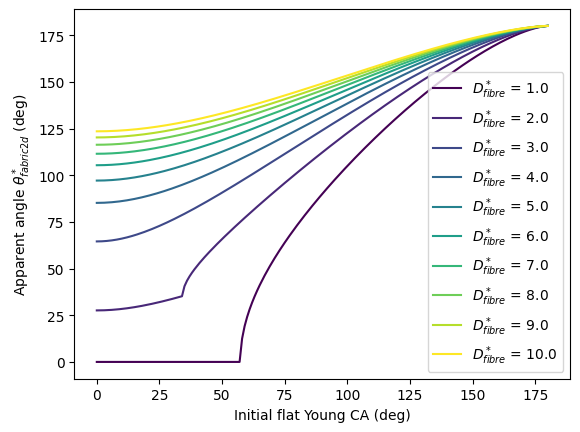

In [ ]:
# Convolve 1D and 2D models

youngs_angle_range = np.arange(0.0, 181, 1)
D_fibre_star_range = np.arange(1.0, 11.0, 1)
cmap = cm.viridis

for i, d_fabric_star in enumerate(D_fibre_star_range):
    color = cmap(i / (len(D_fibre_star_range) - 1))
    # Calculate 1D model
    thetas_fibre_1d = theta_fibre_star(np.deg2rad(youngs_angle_range), d_fabric_star)
    thetas_fibre_1d = np.nan_to_num(thetas_fibre_1d, 0)
    # plt.plot(youngs_angle_range, np.rad2deg(thetas_fibre_1d), color=color, linestyle='--', alpha=0.5)

    # Calculate 2D model
    thetas_fabric_2d = theta_fabric_2d_star(
        np.deg2rad(youngs_angle_range), d_fabric_star
    )
    thetas_fabric_2d = np.nan_to_num(thetas_fabric_2d, 0)
    # plt.plot(youngs_angle_range, np.rad2deg(thetas_fabric_2d), color=color, linestyle=':', alpha=0.5)

    # Calculate midpoint
    thetas_convolved = (thetas_fibre_1d + thetas_fabric_2d) / 2
    plt.plot(
        youngs_angle_range,
        np.rad2deg(thetas_convolved),
        color=color,
        label=f"$D_{{fibre}}^*$ = {d_fabric_star}",
    )

plt.ylabel(r"Apparent angle $\theta^*_{fabric 2d}$ (deg)")
plt.xlabel(r"Initial flat Young CA (deg)")
plt.legend()
plt.show()

# Modelling


In [ ]:
liquid_dict = {
    "water": {
        "surface_tension_lv": 72e-3,  # N/m
        "liquid_density": 1000,  # kg/m3
    },
    "hexadecane": {
        "surface_tension_lv": 27e-3,  # N/m
        "liquid_density": 773,  # kg/m3
    },
    "olive oil": {
        "surface_tension_lv": 32e-3,  # N/m
        "liquid_density": 917,  # kg/m3
    },
}

In [ ]:
# Inputs (for bamboo and chitosan)
liquid = "water"
fibre_thickness_diameter = 80e-6  # m
spacing_between_fibres = 80e-6  # m
flat_young_contact_angle = 80  # deg with the material of interest
desired_contact_angle = 140  # deg
particle_diameter_sphere = 1e-6  # m (assume it's a sphere)
a_star_stability_value = 10  # The larger, the more stable it is.

In [ ]:
# Estimate fibre D*_fibre
D_star_exp = porosity_cylindrical_fibres(
    spacing_between_fibres / 2, fibre_thickness_diameter / 2
)
print(f"Estimated D* fibre = {D_star_exp}")

# Calculate the convolved 1d-2d fibre model (FIBRE ONLY MODEL)
print("#### FIBRE ONLY MODEL ####")
flat_young_contact_angle_rad = np.deg2rad(flat_young_contact_angle)
theta_fibre_1d = theta_fibre_star(flat_young_contact_angle_rad, D_star_exp)
theta_fibre_1d = np.nan_to_num(np.asarray(theta_fibre_1d), nan=0)
# Calculate 2D model
theta_fabric_2d = theta_fabric_2d_star(flat_young_contact_angle_rad, D_star_exp)
theta_fabric_2d = np.nan_to_num(np.asarray(theta_fabric_2d), nan=0)
# Thetas convolved
thetas_convolved = (theta_fibre_1d + theta_fabric_2d) / 2
print(
    f"Apparent theta convolved: {np.rad2deg(thetas_convolved):.1f} deg (1d: {np.rad2deg(theta_fibre_1d):.0f}, 2d: {np.rad2deg(theta_fabric_2d):.0f})"
)

# Calculate the hierarchical model
print("#### HIERARCHICAL MODEL ####")
# What is the apparent particle angle needed for the desired contact angle?
desired_theta_particle = isolate_theta_particle_star_from_theta_hierarchical_star(
    desired_contact_angle, D_star_exp
)
print(f"Desired theta particle star: {np.rad2deg(desired_theta_particle):.1f} deg")
desired_d_particle_start = isolate_D_particle_star(
    flat_young_contact_angle_rad, desired_theta_particle
)
desired_particle_spacing_um = (
    2
    * isolate_spacing_btw_particles(desired_d_particle_start, particle_diameter_sphere)
    * 1e6
)
print(f"Desired inter-particle spacing: {desired_particle_spacing_um:.3f} um")
# Stability check - is this system within A*>10 (A* == pressure required to force a wetting transition)
surface_tension_lv = liquid_dict[liquid]["surface_tension_lv"]
liquid_density = liquid_dict[liquid]["liquid_density"]
l_capilary = capilary_length_liquid(surface_tension_lv, liquid_density)
max_fibre_d_star = D_fibre_max_star(
    desired_theta_particle,
    l_capilary,
    a_star_stability_value,
    fibre_thickness_diameter / 2,
)
is_stable = max_fibre_d_star <= D_star_exp
print(f"#### Stability check (for {liquid}) ####")
print(
    f"Is this setup stable for A* = {a_star_stability_value:.0f}? {is_stable} (max d_star is {max_fibre_d_star:.1f})"
)

Estimated D* fibre = 1.5
#### FIBRE ONLY MODEL ####
Apparent theta convolved: 89.9 deg (1d: 98, 2d: 82)
#### HIERARCHICAL MODEL ####
Desired theta particle star: 99.1 deg
Desired inter-particle spacing: 0.871 um
#### Stability check (for water) ####
Is this setup stable for A* = 10? False (max d_star is 3.0)


# Widget


In [ ]:
# WIDGET
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Create sliders for input parameters
liquid = widgets.Dropdown(
    options=[key for key in liquid_dict.keys()], description="Liquid:"
)

fibre_thickness_diameter_slider = widgets.FloatSlider(
    value=80, min=0.1, max=100, step=0.1, description="Fibre Diameter (um):"
)

spacing_between_fibres_slider = widgets.FloatSlider(
    value=80, min=0.1, max=100, step=0.1, description="Spacing between Fibres (um):"
)

flat_young_contact_angle_slider = widgets.FloatSlider(
    value=80, min=0, max=180, step=1, description="Flat Young Contact Angle (deg):"
)

desired_contact_angle_slider = widgets.FloatSlider(
    value=140, min=0, max=180, step=1, description="Desired Contact Angle (deg):"
)

particle_diameter_sphere_slider = widgets.FloatSlider(
    value=1, min=0.01, max=10, step=0.01, description="Particle Diameter (um):"
)

a_star_stability_value_slider = widgets.FloatSlider(
    value=10, min=1, max=100, step=1, description="A* Stability Value:"
)

# Output area for results
output = widgets.Output()


# Function to update the output
def update_output(change):
    with output:
        # Get the current slider values
        liquid_value = liquid.value
        fibre_thickness_diameter_value = fibre_thickness_diameter_slider.value * 1e-6
        spacing_between_fibres_value = spacing_between_fibres_slider.value * 1e-6
        flat_young_contact_angle_value = flat_young_contact_angle_slider.value
        desired_contact_angle_value = desired_contact_angle_slider.value
        particle_diameter_sphere_value = particle_diameter_sphere_slider.value * 1e-6
        a_star_stability_value_value = a_star_stability_value_slider.value

        # Call your functions with the slider values
        D_star_exp = porosity_cylindrical_fibres(
            spacing_between_fibres_value / 2, fibre_thickness_diameter_value / 2
        )
        theta_fibre_1d = theta_fibre_star(
            np.deg2rad(flat_young_contact_angle_value), D_star_exp
        )
        theta_fibre_1d = np.nan_to_num(np.asarray(theta_fibre_1d), nan=0)
        theta_fabric_2d = theta_fabric_2d_star(
            np.deg2rad(flat_young_contact_angle_value), D_star_exp
        )
        theta_fabric_2d = np.nan_to_num(np.asarray(theta_fabric_2d), nan=0)
        thetas_convolved = (theta_fibre_1d + theta_fabric_2d) / 2
        desired_theta_particle = (
            isolate_theta_particle_star_from_theta_hierarchical_star(
                desired_contact_angle_value, D_star_exp
            )
        )
        desired_d_particle_start = isolate_D_particle_star(
            np.deg2rad(flat_young_contact_angle_value), desired_theta_particle
        )
        desired_particle_spacing_um = (
            2
            * isolate_spacing_btw_particles(
                desired_d_particle_start, particle_diameter_sphere_value
            )
            * 1e6
        )
        surface_tension_lv = liquid_dict[liquid_value]["surface_tension_lv"]
        liquid_density = liquid_dict[liquid_value]["liquid_density"]
        l_capilary = capilary_length_liquid(surface_tension_lv, liquid_density)
        max_fibre_d_star = D_fibre_max_star(
            desired_theta_particle,
            l_capilary,
            a_star_stability_value_value,
            fibre_thickness_diameter_value / 2,
        )
        is_stable = max_fibre_d_star <= D_star_exp

        # Print the results
        output.clear_output()
        print(f"Estimated D* fibre = {D_star_exp}")
        print("#### FIBRE ONLY MODEL ####")
        print(
            f"Apparent theta convolved: {np.rad2deg(thetas_convolved):.1f} deg (1d: {np.rad2deg(theta_fibre_1d):.0f}, 2d: {np.rad2deg(theta_fabric_2d):.0f})"
        )
        print("#### HIERARCHICAL MODEL ####")
        print(
            f"Desired theta particle star: {np.rad2deg(desired_theta_particle):.1f} deg"
        )
        print(f"Desired inter-particle spacing: {desired_particle_spacing_um:.3f} um")
        print("#### STABLITY ESTIMATATION ####")
        print(
            f"Is this setup stable for A* = {a_star_stability_value_value:.0f}? {is_stable} (max d_star is {max_fibre_d_star:.1f})"
        )


# Attach the update_output function to slider value changes
liquid.observe(update_output, names="value")
fibre_thickness_diameter_slider.observe(update_output, names="value")
spacing_between_fibres_slider.observe(update_output, names="value")
flat_young_contact_angle_slider.observe(update_output, names="value")
desired_contact_angle_slider.observe(update_output, names="value")
particle_diameter_sphere_slider.observe(update_output, names="value")
a_star_stability_value_slider.observe(update_output, names="value")

# Display the widgets
display(
    liquid,
    fibre_thickness_diameter_slider,
    spacing_between_fibres_slider,
    flat_young_contact_angle_slider,
    desired_contact_angle_slider,
    particle_diameter_sphere_slider,
    a_star_stability_value_slider,
    output,
)

Dropdown(description='Liquid:', options=('water', 'hexadecane', 'olive oil'), value='water')

FloatSlider(value=80.0, description='Fibre Diameter (um):', min=0.1)

FloatSlider(value=80.0, description='Spacing between Fibres (um):', min=0.1)

FloatSlider(value=80.0, description='Flat Young Contact Angle (deg):', max=180.0, step=1.0)

FloatSlider(value=140.0, description='Desired Contact Angle (deg):', max=180.0, step=1.0)

FloatSlider(value=1.0, description='Particle Diameter (um):', max=10.0, min=0.01, step=0.01)

FloatSlider(value=10.0, description='A* Stability Value:', min=1.0, step=1.0)

Output()

# Plots


/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  A_hierarchical_star = (l_cap / (R_fibre * (D_fibre_star - 1))) * ((1 - np.cos(theta_particle_star)) / (D_fibre_star - 1 + 2 * np.sin(theta_particle_star)))


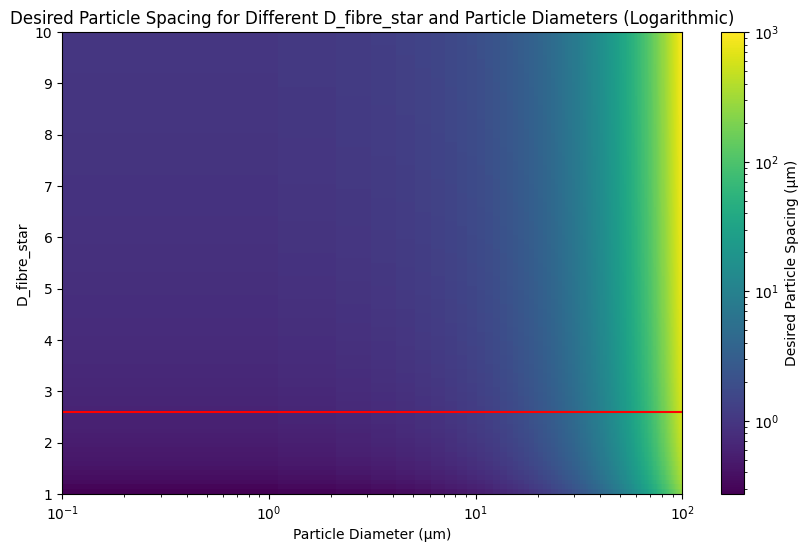

In [ ]:
# Plot with contour where A* is less than a_star_stability_value (10)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Constants and default parameters
flat_young_contact_angle = 0  # deg
desired_contact_angle = 140  # deg
a_star_stability_value = 10
fibre_thickness_diameter = 100e-6  # m
liquid = "olive oil"

# Get the parameters from the dictionary
surface_tension_lv = liquid_dict[liquid]["surface_tension_lv"]
liquid_density = liquid_dict[liquid]["liquid_density"]

# Define the range of D_fibre_star and particle_diameter_sphere
D_fibre_star_values = np.linspace(1, 10, 100)
particle_diameter_sphere_values = np.logspace(-7, -4, 100)

# Create an empty grid to store desired_particle_spacing_um values
grid = np.zeros((len(D_fibre_star_values), len(particle_diameter_sphere_values)))
grid_a_star = np.zeros((len(D_fibre_star_values), len(particle_diameter_sphere_values)))

# Calculate desired_particle_spacing_um and A_star for each grid position
for i, D_fibre_star in enumerate(D_fibre_star_values):
    for j, particle_diameter_sphere in enumerate(particle_diameter_sphere_values):
        desired_theta_particle = (
            isolate_theta_particle_star_from_theta_hierarchical_star(
                desired_contact_angle, D_fibre_star
            )
        )
        desired_d_particle_start = isolate_D_particle_star(
            np.deg2rad(flat_young_contact_angle), desired_theta_particle
        )
        desired_particle_spacing_um = (
            2
            * isolate_spacing_btw_particles(
                desired_d_particle_start, particle_diameter_sphere
            )
            * 1e6
        )
        grid[i, j] = desired_particle_spacing_um

        # Calculate A_star for each point in the grid
        l_capilary = capilary_length_liquid(surface_tension_lv, liquid_density)
        a_star_local = A_hierarchical_star(
            desired_theta_particle,
            D_fibre_star,
            l_capilary,
            fibre_thickness_diameter / 2,
        )
        grid_a_star[i, j] = a_star_local

# Create a heatmap plot with a logarithmic color map
plt.figure(figsize=(10, 6))
im = plt.imshow(
    grid,
    extent=[
        np.min(particle_diameter_sphere_values) * 1e6,
        np.max(particle_diameter_sphere_values) * 1e6,
        np.min(D_fibre_star_values),
        np.max(D_fibre_star_values),
    ],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    norm=LogNorm(),
)

# Overlay the contour where grid_a_star switches from below 10 to above 10
contour = plt.contour(
    particle_diameter_sphere_values * 1e6,
    D_fibre_star_values,
    grid_a_star,
    levels=[10],
    colors="red",
)

# Add colorbar for the heatmap
cbar = plt.colorbar(im, label="Desired Particle Spacing (µm)")

plt.xlabel("Particle Diameter (µm)")
plt.ylabel("D_fibre_star")
plt.title(
    "Desired Particle Spacing for Different D_fibre_star and Particle Diameters (Logarithmic)"
)

plt.xscale("log")
plt.show()

/var/folders/9s/11sjwkvj3j341mcwss0fwk080000gn/T/ipykernel_70835/1002177954.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  A_hierarchical_star = (l_cap / (R_fibre * (D_fibre_star - 1))) * ((1 - np.cos(theta_particle_star)) / (D_fibre_star - 1 + 2 * np.sin(theta_particle_star)))


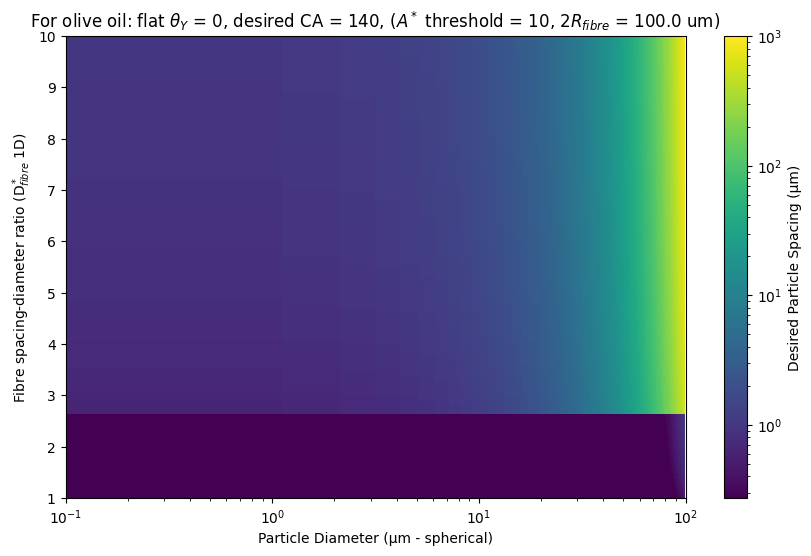

In [ ]:
# Plot with masked A* where A* is less than a_star_stability_value (10)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Constants and default parameters
flat_young_contact_angle = 0  # deg
desired_contact_angle = 140  # deg
a_star_stability_value = 10
fibre_thickness_diameter = 100e-6  # m
liquid = "olive oil"

# Get the parameters from the dictionary
surface_tension_lv = liquid_dict[liquid]["surface_tension_lv"]
liquid_density = liquid_dict[liquid]["liquid_density"]

# Define the range of D_fibre_star and particle_diameter_sphere
D_fibre_star_values = np.linspace(1, 10, 100)
particle_diameter_sphere_values = np.logspace(-7, -4, 100)

# Create an empty grid to store desired_particle_spacing_um values
grid = np.zeros((len(D_fibre_star_values), len(particle_diameter_sphere_values)))
grid_a_star = np.zeros((len(D_fibre_star_values), len(particle_diameter_sphere_values)))

# Calculate desired_particle_spacing_um and A_star for each grid position
for i, D_fibre_star in enumerate(D_fibre_star_values):
    for j, particle_diameter_sphere in enumerate(particle_diameter_sphere_values):
        desired_theta_particle = (
            isolate_theta_particle_star_from_theta_hierarchical_star(
                desired_contact_angle, D_fibre_star
            )
        )
        desired_d_particle_start = isolate_D_particle_star(
            np.deg2rad(flat_young_contact_angle), desired_theta_particle
        )
        desired_particle_spacing_um = (
            2
            * isolate_spacing_btw_particles(
                desired_d_particle_start, particle_diameter_sphere
            )
            * 1e6
        )
        grid[i, j] = desired_particle_spacing_um

        # Calculate A_star for each point in the grid
        l_capilary = capilary_length_liquid(surface_tension_lv, liquid_density)
        a_star_local = A_hierarchical_star(
            desired_theta_particle,
            D_fibre_star,
            l_capilary,
            fibre_thickness_diameter / 2,
        )
        grid_a_star[i, j] = a_star_local

# Create a heatmap plot with a logarithmic color map
plt.figure(figsize=(10, 6))
im = plt.imshow(
    grid,
    extent=[
        np.min(particle_diameter_sphere_values) * 1e6,
        np.max(particle_diameter_sphere_values) * 1e6,
        np.min(D_fibre_star_values),
        np.max(D_fibre_star_values),
    ],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    norm=LogNorm(),
)

# Change the alpha value for the masked area (grid_a_star >= a_star_stability_value)
alpha_mask = np.where(grid_a_star >= a_star_stability_value, 0.002, 1)
im.set_array(im.get_array() * alpha_mask)

# Add colorbar for the heatmap
cbar = plt.colorbar(im, label="Desired Particle Spacing (µm)")

plt.xlabel("Particle Diameter (µm - spherical)")
plt.ylabel("Fibre spacing-diameter ratio (D$^*_{fibre}$ 1D)")
title = f"For {liquid}: flat $\\theta_Y$ = {flat_young_contact_angle}, desired CA = {desired_contact_angle}, ($A^*$ threshold = {a_star_stability_value}, $2R_{{fibre}}$ = {fibre_thickness_diameter*1e6} um)"
plt.title(title)

plt.xscale("log")
plt.show()